In [29]:
import numpy as np
from io import StringIO
import requests
import pandas as pd
import matplotlib.pyplot as plt
import random

In [30]:
ano = 2024
rodada = 5
prefixo = "df_rodada"
nome_dataframe = prefixo + str(rodada)

url = f"https://raw.githubusercontent.com/henriquepgomide/caRtola/master/data/01_raw/{ano}/rodada-{rodada}.csv"
response = requests.get(url)
data = response.content

globals()[nome_dataframe] = pd.read_csv(StringIO(data.decode('utf-8')),usecols=['atletas.variacao_num', 'atletas.media_num',
        'atletas.rodada_id', 'atletas.jogos_num','atletas.pontos_num','atletas.slug','atletas.apelido',
       'atletas.clube.id.full.name', 'atletas.atleta_id', 'atletas.status_id',
       'atletas.posicao_id', 'atletas.preco_num'])

globals()[nome_dataframe].fillna(0, inplace=True)

In [39]:
df_rodada5[df_rodada5['atletas.apelido'] == 'Wesley']

,atletas.clube.id.full.name,atletas.pontos_num,atletas.status_id,atletas.media_num,atletas.atleta_id,atletas.posicao_id,atletas.rodada_id,atletas.jogos_num,atletas.preco_num,atletas.apelido,atletas.slug,atletas.variacao_num
411,Internacional,0.0,7,10.42,105811,5,5,4,12.14,Wesley,wesley,0.00
534,Flamengo,0.4,7,1.00,115239,2,5,2,2.95,Wesley,wesley,-0.08
574,Corinthians,0.9,7,6.00,117909,5,5,5,7.02,Wesley,wesley,-1.72


In [15]:
mask = df_rodada5['atletas.status_id'] == 7
df_rodada5 = df_rodada5[mask]

In [16]:
mask = df_rodada5['atletas.posicao_id'] != 6
df_rodada5 = df_rodada5[mask]

In [17]:
df_rodada5 = df_rodada5.sort_values(by=['atletas.posicao_id']).reset_index(drop=True)

In [18]:
def formacao_irregular(genotipo):
  jogadores_escolhidos = np.where(genotipo == 1)[0]
  jogadores_escolhidos = np.sort(jogadores_escolhidos)

  posicoes = []
  for i in jogadores_escolhidos:
    posicoes.append(df_rodada5['atletas.posicao_id'].iloc[i])

  counts = {}
  for i in range(1, 6):
    counts[i] = posicoes.count(i)

  if counts.get(1, 0) == 0:
    return True

  escalacao = str(counts.get(2, 0)) + str(counts.get(3, 0)) + str(counts.get(4, 0)) + str(counts.get(5, 0))
  # Strings para comparar
  formacoes = ['0343', '0352', '2233', '2242', '2251', '2332', '2341']

  # Verificando se escalacao é igual a alguma das strings
  if escalacao in formacoes:
      return False
  else:
      return True


In [19]:
def calcula_fitness_mochila(genotipo,preço_jogadores,pontuacao_jogadores,preco_maximo):
  preço_total = np.sum(genotipo * preço_jogadores)
  pontuacao_total = np.sum(genotipo * pontuacao_jogadores)
  num_jogadores = np.sum(genotipo * 1)
  if num_jogadores != 11:
    return -1
  if formacao_irregular(genotipo):
    return -0.1
  if preço_total > preco_maximo:
    return -0.01
  else:
    return pontuacao_total

In [20]:
def gerar_populacao_controlada(tamanho_da_populacao, tamanho_do_genoma, max_uns=11):
    populacao = np.zeros((tamanho_da_populacao, tamanho_do_genoma), dtype=int)

    for i in range(tamanho_da_populacao):
        indices = np.random.permutation(tamanho_do_genoma)
        uns_indices = indices[:max_uns]
        populacao[i, uns_indices] = 1

    return populacao

In [21]:
def cruzamento_troca_posicao_dos_uns(pai1, pai2):
    pos_uns_pai1 = np.where(pai1 == 1)[0]
    pos_uns_pai2 = np.where(pai2 == 1)[0]

    pos_uns_pai1 = np.sort(pos_uns_pai1)
    pos_uns_pai2 = np.sort(pos_uns_pai2)

    # Assume que os pais sempre têm 11 'uns'
    num_uns = 11
    num_uns_pai1_part = 8
    num_uns_pai2_part = num_uns - num_uns_pai1_part

    filho1 = np.zeros_like(pai1)
    filho2 = np.zeros_like(pai2)



    # Criar filho1 e filho2
    filho1[pos_uns_pai1[:num_uns_pai1_part]] = 1
    filho1[pos_uns_pai2[-num_uns_pai2_part:]] = 1

    filho2[pos_uns_pai2[:num_uns_pai1_part]] = 1
    filho2[pos_uns_pai1[-num_uns_pai2_part:]] = 1

    return filho1, filho2

In [22]:
def mutacao(genotipo,indice):
    pos_uns = np.where(genotipo == 1)[0]
    pos_uns = np.sort(pos_uns)

    if len(pos_uns) < 11:
      return genotipo

    id_jogador_saindo = pos_uns[indice]
    genotipo[id_jogador_saindo] = 0

    # Definindo o limite superior e a lista de números excluídos
    limite = len(genotipo)
    excluir = pos_uns

    # Criando uma lista de números de 1 até o limite
    numeros = list(range(0, limite))

    # Removendo os números excluídos da lista
    numeros_filtrados = [num for num in numeros if num not in excluir]

    # Selecionando um número aleatório da lista filtrada
    id_jogador_entrando = random.choice(numeros_filtrados)


    genotipo[id_jogador_entrando] = 0


    return genotipo

In [27]:
preco_jogadores = np.array(df_rodada5['atletas.preco_num'])
pontuacao_jogadores = np.array(df_rodada5['atletas.media_num'])
preco_maximo_time  = 120
taxa_de_mutacao = 0.05
tamanho_da_populacao = 500000
tamanho_do_genoma = len(preco_jogadores)
fitness_ideal = sum(pontuacao_jogadores) * 0.5
geracao_limit = 20

Melhor Aptidão Encontrada: 79.69
Melhor Time:
Carlos Miguel - Corinthians - 1 - 7.25
Piquerez - Palmeiras - 2 - 7.85
Zé Guilherme - Grêmio - 2 - 2.67
Cacá - Corinthians - 3 - 9.2
Félix Torres - Corinthians - 3 - 5.18
De la Cruz - Flamengo - 4 - 9.96
Danilo Barbosa - Botafogo - 4 - 5.5
Erick - Athlético-PR - 4 - 6.98
Lucas Barbosa - Juventude - 5 - 8.68
Wesley - Corinthians - 5 - 6.0
Wesley - Internacional - 5 - 10.42
Preço do melhor genótipo: 105.78
Geração 19


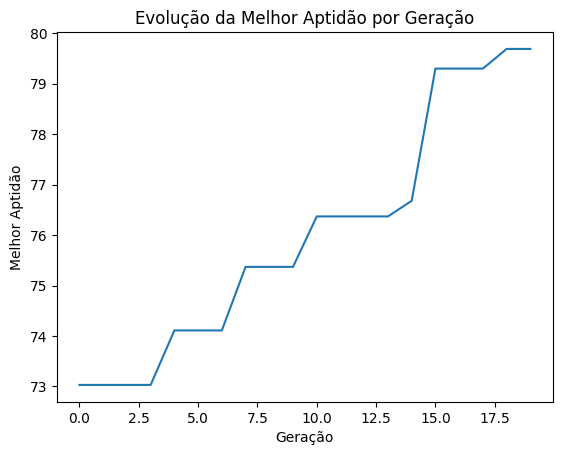

In [28]:
# Geração inicial da população
populacao = gerar_populacao_controlada(tamanho_da_populacao, tamanho_do_genoma)

# Lista para armazenar a melhor aptidão em cada geração
melhor_aptidao_por_geracao = []

for geracao in range(geracao_limit):
    fitness_do_pontuacao_jogadores = []

    for genotipo in range(tamanho_da_populacao):
        fitness_do_pontuacao_jogadores.append(calcula_fitness_mochila(populacao[genotipo], preco_jogadores, pontuacao_jogadores, preco_maximo_time))

    melhor_fitness_encontrada = np.max(fitness_do_pontuacao_jogadores)
    melhor_idx = np.argmax(fitness_do_pontuacao_jogadores)
    melhor_genotipo = populacao[melhor_idx]

    # Armazena a melhor aptidão desta geração
    melhor_aptidao_por_geracao.append(melhor_fitness_encontrada)

    if melhor_fitness_encontrada >= fitness_ideal:
        break

    # Seleção dos pais
    pais = np.zeros((tamanho_da_populacao, tamanho_do_genoma))
    for i in range(tamanho_da_populacao):
        idx1 = np.random.randint(tamanho_da_populacao)
        idx2 = np.random.randint(tamanho_da_populacao)
        if fitness_do_pontuacao_jogadores[idx1] > fitness_do_pontuacao_jogadores[idx2]:
            pais[i, :] = populacao[idx1, :]
        else:
            pais[i, :] = populacao[idx2, :]

    # Cruzamento
    offspring = np.zeros_like(pais)
    for i in range(round(tamanho_da_populacao / 2)):
        pai1 = np.random.randint(tamanho_da_populacao)
        pai2 = np.random.randint(tamanho_da_populacao)
        filho1, filho2 = cruzamento_troca_posicao_dos_uns(pais[pai1], pais[pai2])
        aux = i * 2
        offspring[aux] = filho1
        offspring[aux + 1] = filho2

    #Mutacao
    for i in range(tamanho_da_populacao):
      for j in range(11):
        if np.random.rand() < taxa_de_mutacao:
          offspring[i] = mutacao(offspring[i],j)


    # Atualiza a população
    populacao = np.vstack((melhor_genotipo, offspring))

print("Melhor Aptidão Encontrada:", melhor_fitness_encontrada)
# print("Melhor Genoma:")
# print(melhor_genotipo)
print("Melhor Time:")
jogadores_escolhidos = np.where(melhor_genotipo == 1)[0]
jogadores_escolhidos = np.sort(jogadores_escolhidos)
for i in jogadores_escolhidos:
    print(df_rodada5['atletas.apelido'].iloc[i], "-",df_rodada5['atletas.clube.id.full.name'].iloc[i], "-", df_rodada5['atletas.posicao_id'].iloc[i], "-", df_rodada5['atletas.media_num'].iloc[i])

preco_total_time = np.sum(melhor_genotipo * preco_jogadores)
print("Preço do melhor genótipo:", preco_total_time)
print("Geração", geracao)


# Plota a evolução da melhor aptidão
plt.plot(melhor_aptidao_por_geracao)
plt.xlabel('Geração')
plt.ylabel('Melhor Aptidão')
plt.title('Evolução da Melhor Aptidão por Geração')
plt.show()